In [1]:
# CatBoost Classification for Crocodile Species
# Baseline and Bayesian tuning with Optuna for comparison with XGBoost

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, classification_report, roc_auc_score

from catboost import CatBoostClassifier
import optuna

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load dataset from root CSV
DATA_PATH = "crocodile_dataset.csv"
raw_df = pd.read_csv(DATA_PATH)
raw_df.head()


C:\Users\ghost\anaconda3\envs\DS3000env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Observation ID,Common Name,Scientific Name,Family,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Date of Observation,Country/Region,Habitat Type,Conservation Status,Observer Name,Notes
0,1,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,1.90,62.0,Adult,Male,31-03-2018,Belize,Swamps,Least Concern,Allison Hill,Cause bill scientist nation opportunity.
1,2,American Crocodile,Crocodylus acutus,Crocodylidae,Crocodylus,4.09,334.5,Adult,Male,28-01-2015,Venezuela,Mangroves,Vulnerable,Brandon Hall,Ago current practice nation determine operatio...
2,3,Orinoco Crocodile,Crocodylus intermedius,Crocodylidae,Crocodylus,1.08,118.2,Juvenile,Unknown,07-12-2010,Venezuela,Flooded Savannas,Critically Endangered,Melissa Peterson,Democratic shake bill here grow gas enough ana...
3,4,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,2.42,90.4,Adult,Male,01-11-2019,Mexico,Rivers,Least Concern,Edward Fuller,Officer relate animal direction eye bag do.
4,5,Mugger Crocodile (Marsh Crocodile),Crocodylus palustris,Crocodylidae,Crocodylus,3.75,269.4,Adult,Unknown,15-07-2019,India,Rivers,Vulnerable,Donald Reid,Class great prove reduce raise author play mov...


Shape: (1000, 15)


,Observation ID,Common Name,Scientific Name,Family,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Date of Observation,Country/Region,Habitat Type,Conservation Status,Observer Name,Notes
0,1,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,1.90,62.0,Adult,Male,31-03-2018,Belize,Swamps,Least Concern,Allison Hill,Cause bill scientist nation opportunity.
1,2,American Crocodile,Crocodylus acutus,Crocodylidae,Crocodylus,4.09,334.5,Adult,Male,28-01-2015,Venezuela,Mangroves,Vulnerable,Brandon Hall,Ago current practice nation determine operatio...
2,3,Orinoco Crocodile,Crocodylus intermedius,Crocodylidae,Crocodylus,1.08,118.2,Juvenile,Unknown,07-12-2010,Venezuela,Flooded Savannas,Critically Endangered,Melissa Peterson,Democratic shake bill here grow gas enough ana...
3,4,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,2.42,90.4,Adult,Male,01-11-2019,Mexico,Rivers,Least Concern,Edward Fuller,Officer relate animal direction eye bag do.
4,5,Mugger Crocodile (Marsh Crocodile),Crocodylus palustris,Crocodylidae,Crocodylus,3.75,269.4,Adult,Unknown,15-07-2019,India,Rivers,Vulnerable,Donald Reid,Class great prove reduce raise author play mov...



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Observation ID        1000 non-null   int64  
 1   Common Name           1000 non-null   object 
 2   Scientific Name       1000 non-null   object 
 3   Family                1000 non-null   object 
 4   Genus                 1000 non-null   object 
 5   Observed Length (m)   1000 non-null   float64
 6   Observed Weight (kg)  1000 non-null   float64
 7   Age Class             1000 non-null   object 
 8   Sex                   1000 non-null   object 
 9   Date of Observation   1000 non-null   object 
 10  Country/Region        1000 non-null   object 
 11  Habitat Type          1000 non-null   object 
 12  Conservation Status   1000 non-null   object 
 13  Observer Name         1000 non-null   object 
 14  Notes                 1000 non-null   object 
dtypes: float64(2), 

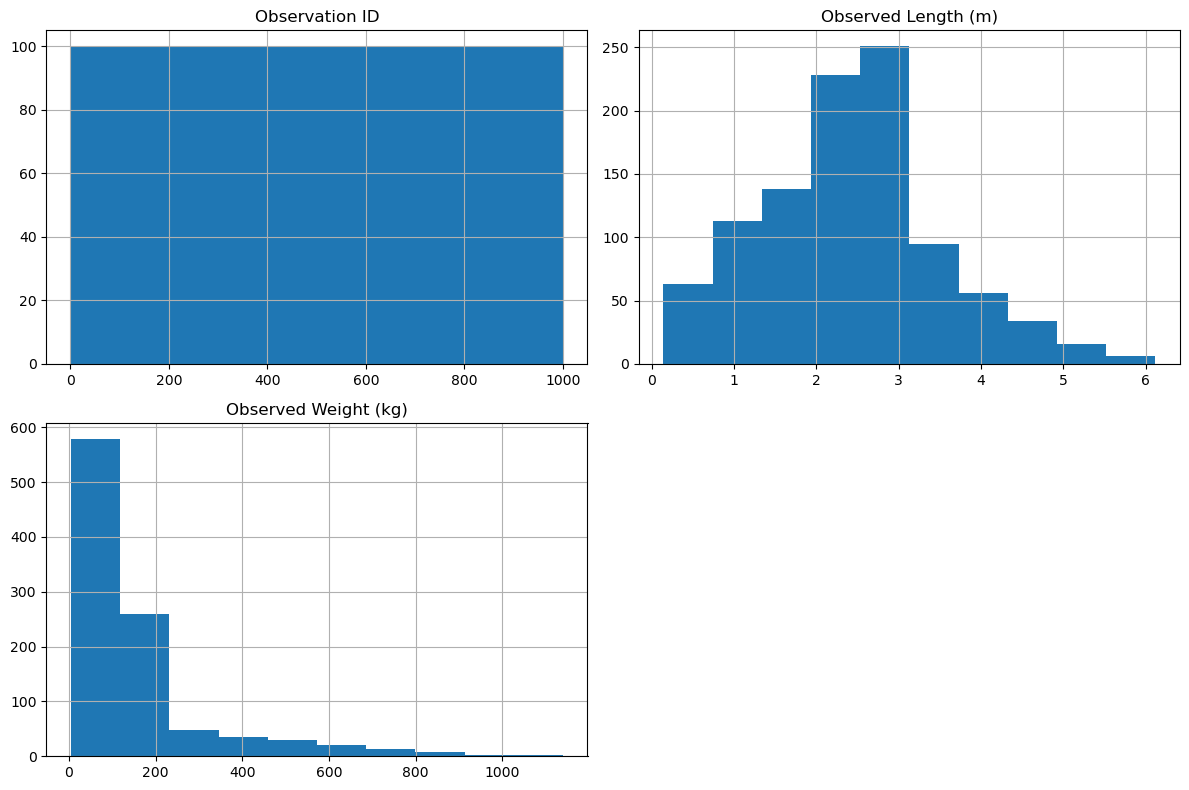

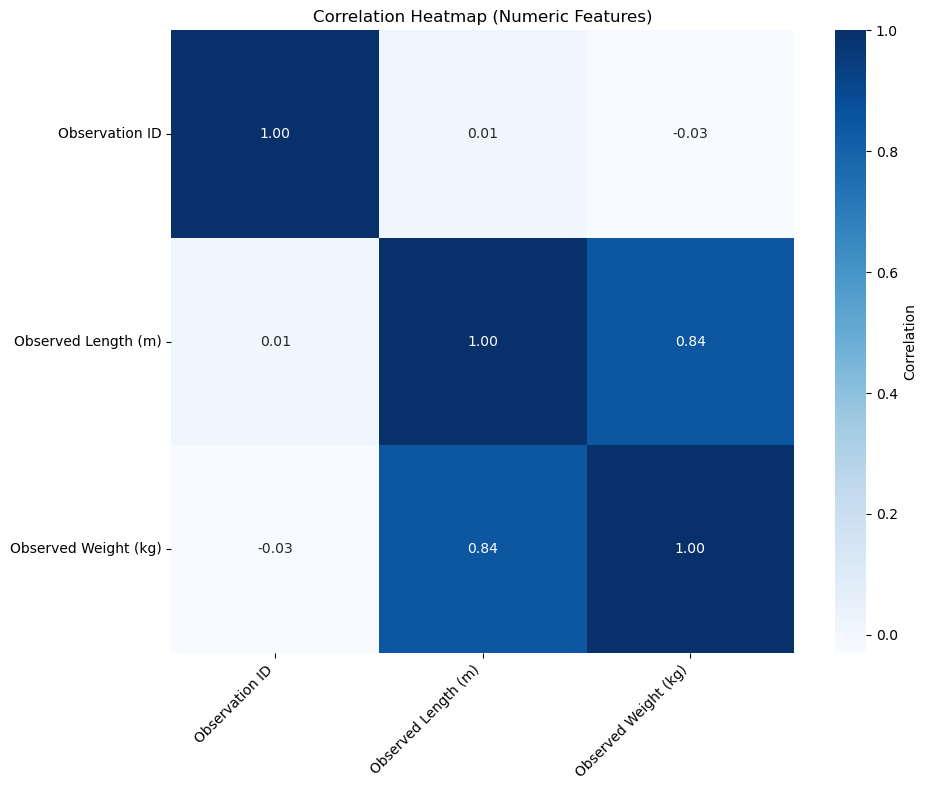

In [2]:
# Basic EDA
print("Shape:", raw_df.shape)
display(raw_df.head())
print("\nInfo:")
print(raw_df.info())

print("\nClass distribution (Common Name):")
print(raw_df['Common Name'].value_counts(normalize=True))

# Example feature distribution plots for numeric columns
numeric_cols = raw_df.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    raw_df[numeric_cols].hist(figsize=(12, 8))
    plt.tight_layout()
    plt.show()

# Correlation heatmap for numerical features
if len(numeric_cols) <= 20 and len(numeric_cols) > 1:
    plt.figure(figsize=(10, 8))
    corr = raw_df[numeric_cols].corr()
    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap='Blues',
        square=True,
        cbar_kws={'label': 'Correlation'}
    )
    plt.title('Correlation Heatmap (Numeric Features)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [3]:
# Preprocessing: remove contested species and leak features, then create train/val split
DF = raw_df.copy()

# Remove contested species to avoid taxonomic ambiguity
CONTESTED_SPECIES_NAME = 'Borneo Crocodile (disputed)'
if CONTESTED_SPECIES_NAME in DF['Common Name'].unique():
    DF = DF[DF['Common Name'] != CONTESTED_SPECIES_NAME].copy()
    print(f"Removed contested species '{CONTESTED_SPECIES_NAME}', new shape: {DF.shape}")

# Drop columns that directly reveal the target (data leakage)
leak_cols = [col for col in ['Observation ID', 'Scientific Name', 'Family', 'Genus', 
                              'Conservation Status', 'Observer Name', 'Notes'] if col in DF.columns]
print("Dropping leak columns:", leak_cols)
DF = DF.drop(columns=leak_cols)

# Extract and transform temporal features
if 'Date of Observation' in DF.columns:
    DF['Date of Observation'] = pd.to_datetime(DF['Date of Observation'], dayfirst=True, errors='coerce')
    DF['Year'] = DF['Date of Observation'].dt.year
    DF['Month'] = DF['Date of Observation'].dt.month
    
    # Normalize year using full dataset statistics before split
    if DF['Year'].notna().any():
        max_year = DF['Year'].max()
        min_year = DF['Year'].min()
        if max_year != min_year:
            DF['Year'] = (DF['Year'] - min_year) / (max_year - min_year)
    
    # Sine transformation preserves cyclic nature of months
    DF['Month'] = np.sin((np.pi * DF['Month']) / 12)
    DF = DF.drop(columns=['Date of Observation'])

# Define features and target (predicting Common Name)
target_col = 'Common Name'
X = DF.drop(columns=[target_col])
y = DF[target_col]

# Identify column types
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Stratified train/validation split for consistent comparison
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y  # Preserve class distribution
)

print(f"Train shape: {X_train.shape}, Valid shape: {X_valid.shape}")
print(f"Number of classes: {len(y.unique())}")

# Encode labels for CatBoost (needs numeric labels for multi-class)
# Flatten to 1D to avoid column-vector warnings
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(np.ravel(y_train))
y_valid_encoded = label_encoder.transform(np.ravel(y_valid))
n_classes = len(label_encoder.classes_)
print(f"Number of classes: {n_classes}")


Removed contested species 'Borneo Crocodile (disputed)', new shape: (933, 15)
Dropping leak columns: ['Observation ID', 'Scientific Name', 'Family', 'Genus', 'Conservation Status', 'Observer Name', 'Notes']
Categorical columns: ['Age Class', 'Sex', 'Country/Region', 'Habitat Type']
Numeric columns: ['Observed Length (m)', 'Observed Weight (kg)', 'Year', 'Month']
Train shape: (746, 8), Valid shape: (187, 8)
Number of classes: 17
Number of classes: 17


CATBOOST BASELINE IMPLEMENTATION

Categorical features (indices): [2, 3, 4, 5]
Categorical feature names: ['Age Class', 'Sex', 'Country/Region', 'Habitat Type']


C:\Users\ghost\anaconda3\envs\DS3000env\lib\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



CatBoost Baseline - Log Loss: 0.2234, Accuracy: 0.9786, AUC-ROC: 1.0000


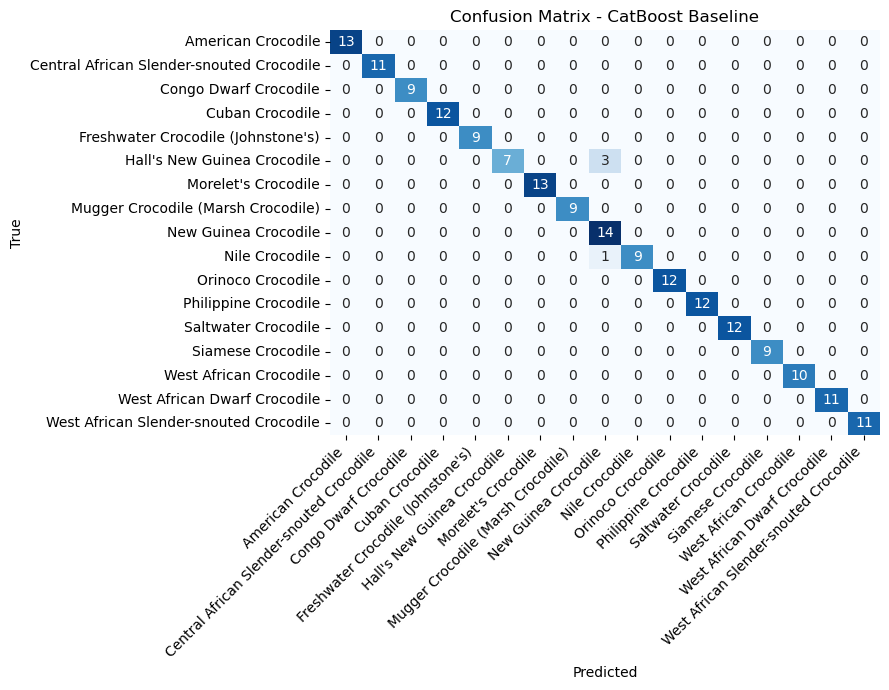

Classification Report:
                                           precision    recall  f1-score   support

                       American Crocodile       1.00      1.00      1.00        13
Central African Slender-snouted Crocodile       1.00      1.00      1.00        11
                    Congo Dwarf Crocodile       1.00      1.00      1.00         9
                          Cuban Crocodile       1.00      1.00      1.00        12
       Freshwater Crocodile (Johnstone's)       1.00      1.00      1.00         9
              Hall's New Guinea Crocodile       1.00      0.70      0.82        10
                      Morelet's Crocodile       1.00      1.00      1.00        13
       Mugger Crocodile (Marsh Crocodile)       1.00      1.00      1.00         9
                     New Guinea Crocodile       0.78      1.00      0.88        14
                           Nile Crocodile       1.00      0.90      0.95        10
                        Orinoco Crocodile       1.00      1.00 

In [4]:
# CatBoost Baseline Implementation
print("="*70)
print("CATBOOST BASELINE IMPLEMENTATION")
print("="*70)

# Identify categorical feature indices for CatBoost
cat_features_indices = [i for i, col in enumerate(X_train.columns) 
                        if col in categorical_cols]

print(f"\nCategorical features (indices): {cat_features_indices}")
print(f"Categorical feature names: {[X_train.columns[i] for i in cat_features_indices]}")

# Baseline hyperparameters
catboost_baseline = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=5,
    loss_function='MultiClass',
    random_seed=RANDOM_STATE,
    verbose=False,
    cat_features=cat_features_indices if cat_features_indices else None
)

catboost_baseline.fit(
    X_train, y_train_encoded,
    cat_features=cat_features_indices if cat_features_indices else None,
    verbose=False
)

# Evaluate baseline model
catboost_baseline_proba = catboost_baseline.predict_proba(X_valid)
catboost_baseline_pred_encoded = catboost_baseline.predict(X_valid)
catboost_baseline_pred = label_encoder.inverse_transform(catboost_baseline_pred_encoded)

catboost_baseline_logloss = log_loss(y_valid_encoded, catboost_baseline_proba)
catboost_baseline_acc = accuracy_score(y_valid, catboost_baseline_pred)
# Calculate AUC-ROC for multi-class (one-vs-rest macro-averaged)
catboost_baseline_auc = roc_auc_score(y_valid_encoded, catboost_baseline_proba, multi_class='ovr', average='macro')

print(f"\nCatBoost Baseline - Log Loss: {catboost_baseline_logloss:.4f}, Accuracy: {catboost_baseline_acc:.4f}, AUC-ROC: {catboost_baseline_auc:.4f}")

# Confusion matrix as readable heatmap
cm_base = confusion_matrix(y_valid, catboost_baseline_pred)
plt.figure(figsize=(9, 7))
sns.heatmap(cm_base,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - CatBoost Baseline', fontsize=12)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Classification Report:")
print(classification_report(y_valid, catboost_baseline_pred))


In [ ]:
# CatBoost with Optuna Hyperparameter Tuning
SKIP_CATBOOST_TUNING = False  # Set to True to skip tuning (use baseline only)

if not SKIP_CATBOOST_TUNING:
    print("="*70)
    print("CATBOOST OPTUNA TUNING")
    print("="*70)
    print("NOTE: This may take several minutes. Interrupt if needed.")
    print("You can skip this by setting SKIP_CATBOOST_TUNING = True above.")
    print("="*70)
    
    N_TRIALS_CAT = 30
    MAX_ITERATIONS = 50  # Limited iterations during tuning to reduce computation time
    
    def catboost_objective(trial):
        # Hyperparameter search space
        params = {
            'iterations': trial.suggest_int('iterations', 30, MAX_ITERATIONS),
            'depth': trial.suggest_int('depth', 3, 7),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 5),
            'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
            'random_strength': trial.suggest_float('random_strength', 0.5, 1.5),
        }
        
        # Bootstrap-specific parameters
        if params['bootstrap_type'] == 'Bayesian':
            params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0.5, 1.0)
        elif params['bootstrap_type'] == 'Bernoulli':
            params['subsample'] = trial.suggest_float('subsample', 0.7, 1.0)
        
        # 2-fold Cross Validation
        skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)
        cv_log_losses = []
        
        y_train_flat = np.array(y_train_encoded).ravel()
        
        for train_idx, valid_idx in skf.split(X_train, y_train_flat):
            X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[valid_idx]
            y_tr = y_train_flat[train_idx]
            y_va = y_train_flat[valid_idx]
            
            # Create fresh model for each fold
            fold_model = CatBoostClassifier(
                loss_function='MultiClass',
                random_seed=RANDOM_STATE,
                verbose=False,
                cat_features=cat_features_indices if cat_features_indices else None,
                early_stopping_rounds=5,
                iterations=params['iterations'],
                **{k: v for k, v in params.items() if k != 'iterations'}
            )
            
            fold_model.fit(X_tr, y_tr, verbose=False)
            proba_va = fold_model.predict_proba(X_va)
            cv_log_losses.append(log_loss(y_va, proba_va))
        
        return np.mean(cv_log_losses)
    
    try:
        # TPE sampler for Bayesian optimization
        catboost_study = optuna.create_study(
            direction='minimize',
            study_name='catboost_crocodiles_opt',
            sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
        )
        catboost_study.optimize(catboost_objective, n_trials=N_TRIALS_CAT, show_progress_bar=False)
        
        print("\nBest trial:")
        print(f"Best CV log loss: {catboost_study.best_trial.value:.4f}")
        print("Best parameters:")
        print(catboost_study.best_trial.params)
        
        # Train final model with best parameters
        best_catboost_params = catboost_study.best_trial.params.copy()
        # Handle bootstrap-specific params
        bootstrap_type = best_catboost_params.pop('bootstrap_type', 'Bayesian')
        if 'bagging_temperature' in best_catboost_params:
            best_catboost_params['bootstrap_type'] = 'Bayesian'
        elif 'subsample' in best_catboost_params:
            best_catboost_params['bootstrap_type'] = 'Bernoulli'
        else:
            best_catboost_params['bootstrap_type'] = bootstrap_type
        
        # Limit final model iterations
        if 'iterations' in best_catboost_params:
            best_catboost_params['iterations'] = min(best_catboost_params['iterations'], 100)
        
        catboost_tuned = CatBoostClassifier(
            loss_function='MultiClass',
            random_seed=RANDOM_STATE,
            verbose=False,
            cat_features=cat_features_indices if cat_features_indices else None,
            early_stopping_rounds=10,
            **best_catboost_params
        )
        
        y_train_catboost = np.array(y_train_encoded).ravel()
        catboost_tuned.fit(X_train, y_train_catboost, verbose=False)
        
        # Evaluate tuned model
        catboost_tuned_proba = catboost_tuned.predict_proba(X_valid)
        catboost_tuned_pred_encoded = catboost_tuned.predict(X_valid)
        catboost_tuned_pred = label_encoder.inverse_transform(catboost_tuned_pred_encoded)
        
        catboost_tuned_logloss = log_loss(y_valid_encoded, catboost_tuned_proba)
        catboost_tuned_acc = accuracy_score(y_valid, catboost_tuned_pred)
        # Calculate AUC-ROC for multi-class (one-vs-rest macro-averaged)
        catboost_tuned_auc = roc_auc_score(y_valid_encoded, catboost_tuned_proba, multi_class='ovr', average='macro')
        
        print(f"\nCatBoost Tuned - Log Loss: {catboost_tuned_logloss:.4f}, Accuracy: {catboost_tuned_acc:.4f}, AUC-ROC: {catboost_tuned_auc:.4f}")

        # Confusion matrix
        cm_tuned = confusion_matrix(y_valid, catboost_tuned_pred)
        plt.figure(figsize=(9, 7))
        sns.heatmap(cm_tuned,
                    annot=True,
                    fmt='d',
                    cmap='Blues',
                    cbar=False,
                    xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_)
        plt.title('Confusion Matrix - CatBoost Tuned', fontsize=12)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        print("Classification Report:")
        print(classification_report(y_valid, catboost_tuned_pred))
        
    except KeyboardInterrupt:
        print("\nCatBoost tuning interrupted. Using baseline only.")
        catboost_tuned = None
        catboost_tuned_logloss = None
        catboost_tuned_acc = None
        catboost_tuned_auc = None
else:
    print("CatBoost tuning skipped (SKIP_CATBOOST_TUNING = True). Using baseline only.")
    catboost_tuned = None
    catboost_tuned_logloss = None
    catboost_tuned_acc = None
    catboost_tuned_auc = None


[I 2025-12-09 13:43:36,856] A new study created in memory with name: catboost_crocodiles_opt


CATBOOST OPTUNA TUNING
NOTE: This may take several minutes. Interrupt if needed.
You can skip this by setting SKIP_CATBOOST_TUNING = True above.


[I 2025-12-09 13:43:53,967] Trial 0 finished with value: 0.5754377853839873 and parameters: {'iterations': 37, 'depth': 7, 'learning_rate': 0.15979909127171077, 'l2_leaf_reg': 3.3946339367881464, 'bootstrap_type': 'Bayesian', 'random_strength': 0.5580836121681995, 'bagging_temperature': 0.9330880728874675}. Best is trial 0 with value: 0.5754377853839873.
[I 2025-12-09 13:44:07,425] Trial 1 finished with value: 1.3179714902152637 and parameters: {'iterations': 42, 'depth': 6, 'learning_rate': 0.05308767414437037, 'l2_leaf_reg': 4.879639408647977, 'bootstrap_type': 'Bayesian', 'random_strength': 0.6818249672071006, 'bagging_temperature': 0.5917022549267169}. Best is trial 0 with value: 0.5754377853839873.
[I 2025-12-09 13:44:22,090] Trial 2 finished with value: 0.6418501821969079 and parameters: {'iterations': 36, 'depth': 5, 'learning_rate': 0.11479175279631737, 'l2_leaf_reg': 2.1649165607921677, 'bootstrap_type': 'Bayesian', 'random_strength': 0.7921446485352182, 'bagging_temperature':

In [ ]:
# Feature Importance Analysis
print("="*70)
print("CATBOOST FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# CatBoost baseline feature importance
if catboost_baseline is not None:
    catboost_baseline_importance = catboost_baseline.get_feature_importance()
    
    catboost_baseline_importance_df = pd.DataFrame({
        'Feature': [X_train.columns[i] if i < len(X_train.columns) else f'Feature_{i}' 
                   for i in range(len(catboost_baseline_importance))],
        'CatBoost_Baseline_Importance': catboost_baseline_importance
    }).sort_values('CatBoost_Baseline_Importance', ascending=False)
    
    print("\nTop 15 Most Important Features (CatBoost Baseline):")
    print(catboost_baseline_importance_df.head(15)[['Feature', 'CatBoost_Baseline_Importance']].to_string(index=False))
    
    # Plot baseline importance
    plt.figure(figsize=(10, 8))
    top_baseline = catboost_baseline_importance_df.head(15)
    plt.barh(range(len(top_baseline)), top_baseline['CatBoost_Baseline_Importance'].values[::-1])
    plt.yticks(range(len(top_baseline)), top_baseline['Feature'].values[::-1], fontsize=9)
    plt.xlabel('Feature Importance', fontsize=11)
    plt.title('Top 15 Features - CatBoost Baseline', fontsize=12, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# CatBoost tuned feature importance if available
if 'catboost_tuned' in locals() and catboost_tuned is not None:
    catboost_tuned_importance = catboost_tuned.get_feature_importance()
    
    catboost_tuned_importance_df = pd.DataFrame({
        'Feature': [X_train.columns[i] if i < len(X_train.columns) else f'Feature_{i}' 
                   for i in range(len(catboost_tuned_importance))],
        'CatBoost_Tuned_Importance': catboost_tuned_importance
    }).sort_values('CatBoost_Tuned_Importance', ascending=False)
    
    print("\n" + "="*70)
    print("Top 15 Most Important Features (CatBoost Tuned):")
    print(catboost_tuned_importance_df.head(15)[['Feature', 'CatBoost_Tuned_Importance']].to_string(index=False))
    
    # Plot tuned importance
    plt.figure(figsize=(10, 8))
    top_tuned = catboost_tuned_importance_df.head(15)
    plt.barh(range(len(top_tuned)), top_tuned['CatBoost_Tuned_Importance'].values[::-1])
    plt.yticks(range(len(top_tuned)), top_tuned['Feature'].values[::-1], fontsize=9)
    plt.xlabel('Feature Importance', fontsize=11)
    plt.title('Top 15 Features - CatBoost Tuned', fontsize=12, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Comparison plot if both available
    if catboost_baseline is not None:
        # Merge for comparison
        comparison_df = catboost_baseline_importance_df.merge(
            catboost_tuned_importance_df, on='Feature', how='inner'
        ).head(10)
        
        plt.figure(figsize=(12, 8))
        x_pos = np.arange(len(comparison_df))
        width = 0.35
        
        plt.barh(x_pos - width/2, comparison_df['CatBoost_Baseline_Importance'].values, 
                 width, label='Baseline', alpha=0.8)
        plt.barh(x_pos + width/2, comparison_df['CatBoost_Tuned_Importance'].values, 
                 width, label='Tuned', alpha=0.8)
        plt.yticks(x_pos, comparison_df['Feature'].values, fontsize=9)
        plt.xlabel('Feature Importance', fontsize=11)
        plt.title('Feature Importance: Baseline vs Tuned', fontsize=12, fontweight='bold')
        plt.legend()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

print("\n" + "="*70)
print("Feature importance analysis complete.")
print("="*70)


In [ ]:
# Model Comparison and Results Summary
print("="*70)
print("CATBOOST MODEL PERFORMANCE SUMMARY")
print("="*70)

# Build results list
results_list = []

# Add baseline model
results_list.append({
    'Model': 'CatBoost Baseline',
    'Log Loss': catboost_baseline_logloss,
    'Accuracy': catboost_baseline_acc,
    'AUC-ROC': catboost_baseline_auc,
    'Notes': 'Default hyperparameters'
})

# Add tuned model if available
if 'catboost_tuned_logloss' in locals() and catboost_tuned_logloss is not None:
    results_list.append({
        'Model': 'CatBoost Tuned (Optuna)',
        'Log Loss': catboost_tuned_logloss,
        'Accuracy': catboost_tuned_acc,
        'AUC-ROC': catboost_tuned_auc if 'catboost_tuned_auc' in locals() and catboost_tuned_auc is not None else None,
        'Notes': 'Bayesian optimized hyperparameters'
    })

results_summary = pd.DataFrame(results_list)

print("\nResults Table (sorted by Accuracy):")
results_sorted = results_summary.sort_values('Accuracy', ascending=False)
print(results_sorted.to_string(index=False))

print("\n" + "="*70)
print("KEY OBSERVATIONS")
print("="*70)

# Find best models
best_acc_model = results_summary.loc[results_summary['Accuracy'].idxmax()]
best_logloss_model = results_summary.loc[results_summary['Log Loss'].idxmin()]
if 'AUC-ROC' in results_summary.columns:
    best_auc_model = results_summary.loc[results_summary['AUC-ROC'].idxmax()]

print(f"\n1. Best Accuracy: {best_acc_model['Model']} ({best_acc_model['Accuracy']:.2%})")
print(f"2. Best Log Loss: {best_logloss_model['Model']} ({best_logloss_model['Log Loss']:.4f})")
if 'AUC-ROC' in results_summary.columns:
    print(f"3. Best AUC-ROC: {best_auc_model['Model']} ({best_auc_model['AUC-ROC']:.4f})")

print(f"\n4. CatBoost Baseline: {catboost_baseline_acc:.2%} accuracy, {catboost_baseline_logloss:.4f} log loss, {catboost_baseline_auc:.4f} AUC-ROC")

if 'catboost_tuned_logloss' in locals() and catboost_tuned_logloss is not None:
    print(f"5. CatBoost Tuned: {catboost_tuned_acc:.2%} accuracy, {catboost_tuned_logloss:.4f} log loss, {catboost_tuned_auc:.4f} AUC-ROC")
    improvement_acc = catboost_tuned_acc - catboost_baseline_acc
    improvement_logloss = catboost_baseline_logloss - catboost_tuned_logloss
    improvement_auc = catboost_tuned_auc - catboost_baseline_auc if 'catboost_tuned_auc' in locals() and catboost_tuned_auc is not None else 0
    if improvement_acc > 0:
        print(f"   -> Tuning improved accuracy by {improvement_acc:.2%}")
    else:
        print(f"   -> Tuning decreased accuracy by {abs(improvement_acc):.2%}")
    if improvement_logloss > 0:
        print(f"   -> Tuning improved log loss by {improvement_logloss:.4f}")
    else:
        print(f"   -> Tuning increased log loss by {abs(improvement_logloss):.4f}")
    if improvement_auc > 0:
        print(f"   -> Tuning improved AUC-ROC by {improvement_auc:.4f}")
    elif improvement_auc < 0:
        print(f"   -> Tuning decreased AUC-ROC by {abs(improvement_auc):.4f}")

print("\n" + "="*70)
print("Note: Compare these results with XGBoost implementation for algorithm comparison.")
print("="*70)
